# Dogecoin LSTM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
dogecoin_csv = os.path.join(current_folder, "data","dogecoin_hourly.csv")
dogecoin_df = pd.read_csv(dogecoin_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
dogecoin_df['highLowDif'] = dogecoin_df['highPriceUsd'] - dogecoin_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
dogecoin_df['datetime'] = pd.to_datetime(dogecoin_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = dogecoin_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = dogecoin_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = dogecoin_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [2]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [3]:
dogecoin_df.iloc[0]

datetime                       2021-02-03 00:00:00+00:00
dogecoin_count                                       757
dogecoin_polarity                               0.181273
dogecoin_subjectivity                           0.517948
dogecoin_polarity_zeros                        0.0900342
dogecoin_subjectivity_zeros                     0.276182
openPriceUsd                                   0.0313916
closePriceUsd                                  0.0337058
highPriceUsd                                   0.0337058
lowPriceUsd                                    0.0313916
volume                                        2941705889
marketcap                                     4321287841
highLowDif                                    0.00231423
Name: 0, dtype: object

In [4]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'dogecoin_polarity', 'dogecoin_subjectivity', 'openPriceUsd','dogecoin_polarity_zeros', 'dogecoin_subjectivity_zeros','dogecoin_count', 'marketcap', 'highLowDif'])

In [5]:
timeperiod_df.iloc[0]

closePriceUsd    3.370579e-02
highPriceUsd     3.370579e-02
lowPriceUsd      3.139156e-02
volume           2.941706e+09
Name: 0, dtype: float64

In [6]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples+validation_samples, 0)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples+validation_samples, 0)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 2160th, validation: 2160th, test: 2400th
Input shape: (128, 120, 4)
Target shape: (128, 1)


In [7]:
# extracting targets from the val_dataset to plot alongside predictions
y_val = np.concatenate([y for x, y in val_dataset], axis=0)

In [8]:
# This doesn't create a full dataset between the points
# find better method if time (like below)
combined_dataset = train_dataset.concatenate(val_dataset)

In [9]:
# setting up customised test_dataset
test_data = timeperiod_df[(training_samples+validation_samples) - lookback + delay:len(timeperiod_df) - delay - 1].to_numpy()

test_targets = timeperiod_df.iloc[(training_samples+validation_samples)+ delay + delay:, timeperiod_df.columns.get_loc("closePriceUsd")]
test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        test_data,
        None,
        sequence_length=lookback,
        sampling_rate=step,
        batch_size=batch_size,
    )

## LSTM models

Epoch 1/20
13/13 [==============================] - 10s 593ms/step - loss: 0.0592 - val_loss: 2.7889
Epoch 2/20
13/13 [==============================] - 6s 466ms/step - loss: 0.0245 - val_loss: 2.6042
Epoch 3/20
13/13 [==============================] - 6s 498ms/step - loss: 0.0228 - val_loss: 2.3395
Epoch 4/20
13/13 [==============================] - 6s 491ms/step - loss: 0.0223 - val_loss: 2.1064
Epoch 5/20
13/13 [==============================] - 7s 540ms/step - loss: 0.0173 - val_loss: 2.0041
Epoch 6/20
13/13 [==============================] - 7s 510ms/step - loss: 0.0174 - val_loss: 1.8546
Epoch 7/20
13/13 [==============================] - 7s 537ms/step - loss: 0.0183 - val_loss: 1.7284
Epoch 8/20
13/13 [==============================] - 7s 552ms/step - loss: 0.0150 - val_loss: 1.6256
Epoch 9/20
13/13 [==============================] - 9s 679ms/step - loss: 0.0154 - val_loss: 1.5890
Epoch 10/20
13/13 [==============================] - 7s 499ms/step - loss: 0.0148 - val_loss: 1.491

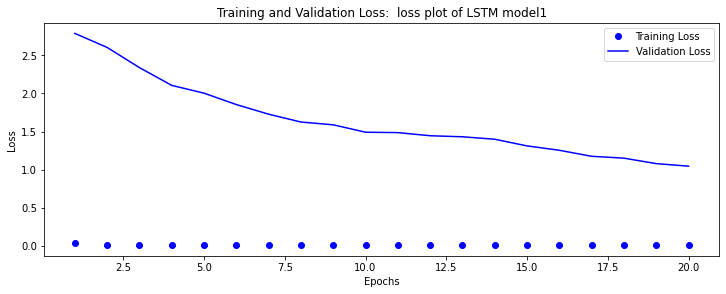

In [10]:
LSTM_model1 = models.Sequential()
LSTM_model1.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model1.add(layers.LSTM(100))


LSTM_model1.add(layers.Dense(1))

LSTM_model1.compile(optimizer=RMSprop(), loss='mse')
LSTM_model1_history = LSTM_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model1_history, "loss plot of LSTM model1")

Epoch 1/20
13/13 [==============================] - 13s 712ms/step - loss: 0.0635 - val_loss: 2.7529
Epoch 2/20
13/13 [==============================] - 7s 546ms/step - loss: 0.0266 - val_loss: 2.5911
Epoch 3/20
13/13 [==============================] - 8s 610ms/step - loss: 0.0267 - val_loss: 2.2004
Epoch 4/20
13/13 [==============================] - 8s 603ms/step - loss: 0.0251 - val_loss: 1.8780
Epoch 5/20
13/13 [==============================] - 7s 575ms/step - loss: 0.0213 - val_loss: 1.7270
Epoch 6/20
13/13 [==============================] - 9s 646ms/step - loss: 0.0222 - val_loss: 1.5055
Epoch 7/20
13/13 [==============================] - 8s 616ms/step - loss: 0.0193 - val_loss: 1.4590
Epoch 8/20
13/13 [==============================] - 8s 665ms/step - loss: 0.0202 - val_loss: 1.3451
Epoch 9/20
13/13 [==============================] - 6s 497ms/step - loss: 0.0195 - val_loss: 1.2301
Epoch 10/20
13/13 [==============================] - 8s 637ms/step - loss: 0.0173 - val_loss: 1.150

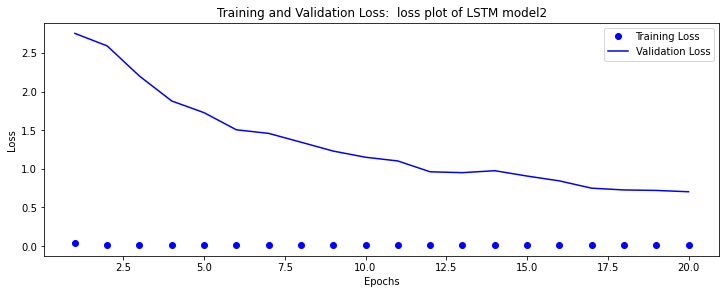

In [11]:
LSTM_model2 = models.Sequential()
LSTM_model2.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model2.add(layers.LSTM(100))


LSTM_model2.add(layers.Dense(1))

LSTM_model2.compile(optimizer=RMSprop(), loss='mse')
LSTM_model2_history = LSTM_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model2_history, "loss plot of LSTM model2")

Epoch 1/20
13/13 [==============================] - 10s 508ms/step - loss: 0.0394 - val_loss: 2.3867
Epoch 2/20
13/13 [==============================] - 6s 498ms/step - loss: 0.0188 - val_loss: 2.2933
Epoch 3/20
13/13 [==============================] - 6s 490ms/step - loss: 0.0188 - val_loss: 2.1359
Epoch 4/20
13/13 [==============================] - 5s 383ms/step - loss: 0.0178 - val_loss: 1.9764
Epoch 5/20
13/13 [==============================] - 5s 432ms/step - loss: 0.0166 - val_loss: 1.8527
Epoch 6/20
13/13 [==============================] - 6s 430ms/step - loss: 0.0158 - val_loss: 1.7669
Epoch 7/20
13/13 [==============================] - 5s 391ms/step - loss: 0.0150 - val_loss: 1.6654
Epoch 8/20
13/13 [==============================] - 5s 424ms/step - loss: 0.0140 - val_loss: 1.5961
Epoch 9/20
13/13 [==============================] - 5s 395ms/step - loss: 0.0138 - val_loss: 1.5092
Epoch 10/20
13/13 [==============================] - 5s 414ms/step - loss: 0.0134 - val_loss: 1.451

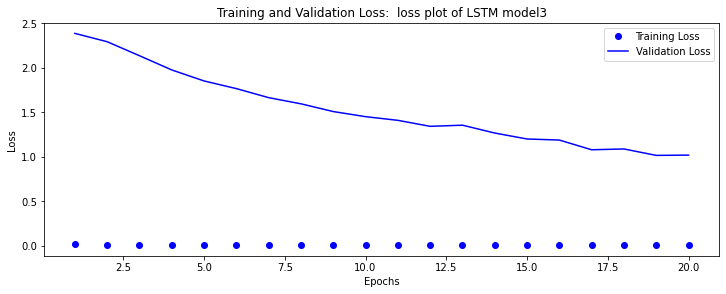

In [12]:
LSTM_model3 = models.Sequential()
LSTM_model3.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model3.add(layers.LSTM(50))


LSTM_model3.add(layers.Dense(1))

LSTM_model3.compile(optimizer=RMSprop(), loss='mse')
LSTM_model3_history = LSTM_model3.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model3_history, "loss plot of LSTM model3")

Epoch 1/20
13/13 [==============================] - 11s 552ms/step - loss: 0.0317 - val_loss: 3.1582
Epoch 2/20
13/13 [==============================] - 6s 475ms/step - loss: 0.0245 - val_loss: 2.8419
Epoch 3/20
13/13 [==============================] - 8s 641ms/step - loss: 0.0209 - val_loss: 2.5756
Epoch 4/20
13/13 [==============================] - 7s 560ms/step - loss: 0.0200 - val_loss: 2.4368
Epoch 5/20
13/13 [==============================] - 6s 455ms/step - loss: 0.0186 - val_loss: 2.2475
Epoch 6/20
13/13 [==============================] - 6s 470ms/step - loss: 0.0172 - val_loss: 2.0857
Epoch 7/20
13/13 [==============================] - 6s 509ms/step - loss: 0.0166 - val_loss: 2.0751
Epoch 8/20
13/13 [==============================] - 7s 525ms/step - loss: 0.0169 - val_loss: 1.9628
Epoch 9/20
13/13 [==============================] - 7s 592ms/step - loss: 0.0160 - val_loss: 1.8586
Epoch 10/20
13/13 [==============================] - 6s 431ms/step - loss: 0.0156 - val_loss: 1.818

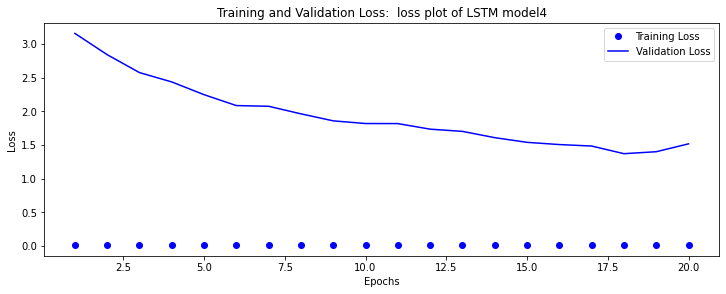

In [13]:
LSTM_model4 = models.Sequential()
LSTM_model4.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model4.add(layers.LSTM(50))


LSTM_model4.add(layers.Dense(1))

LSTM_model4.compile(optimizer=RMSprop(), loss='mse')
LSTM_model4_history = LSTM_model4.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model4_history, "loss plot of LSTM model4")

Epoch 1/30
13/13 [==============================] - 10s 480ms/step - loss: 0.0438 - val_loss: 3.3276
Epoch 2/30
13/13 [==============================] - 5s 422ms/step - loss: 0.0251 - val_loss: 3.0271
Epoch 3/30
13/13 [==============================] - 4s 305ms/step - loss: 0.0189 - val_loss: 2.8706
Epoch 4/30
13/13 [==============================] - 4s 308ms/step - loss: 0.0162 - val_loss: 2.7870
Epoch 5/30
13/13 [==============================] - 5s 425ms/step - loss: 0.0148 - val_loss: 2.7357
Epoch 6/30
13/13 [==============================] - 4s 298ms/step - loss: 0.0139 - val_loss: 2.6913
Epoch 7/30
13/13 [==============================] - 4s 303ms/step - loss: 0.0133 - val_loss: 2.6094
Epoch 8/30
13/13 [==============================] - 5s 358ms/step - loss: 0.0127 - val_loss: 2.5523
Epoch 9/30
13/13 [==============================] - 4s 303ms/step - loss: 0.0127 - val_loss: 2.4846
Epoch 10/30
13/13 [==============================] - 4s 309ms/step - loss: 0.0119 - val_loss: 2.399

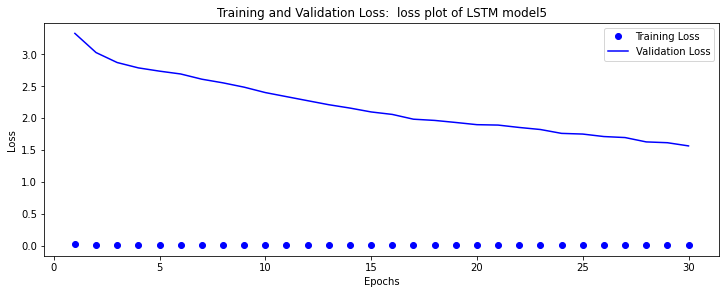

In [14]:
LSTM_model5 = models.Sequential()
LSTM_model5.add(layers.LSTM(50, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model5.add(layers.LSTM(50))


LSTM_model5.add(layers.Dense(1))

LSTM_model5.compile(optimizer=RMSprop(), loss='mse')
LSTM_model5_history = LSTM_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model5_history, "loss plot of LSTM model5")

Epoch 1/20
13/13 [==============================] - 10s 410ms/step - loss: 0.0499 - val_loss: 4.1961
Epoch 2/20
13/13 [==============================] - 4s 332ms/step - loss: 0.0289 - val_loss: 3.9513
Epoch 3/20
13/13 [==============================] - 4s 341ms/step - loss: 0.0249 - val_loss: 3.7081
Epoch 4/20
13/13 [==============================] - 6s 437ms/step - loss: 0.0211 - val_loss: 3.5597
Epoch 5/20
13/13 [==============================] - 4s 343ms/step - loss: 0.0200 - val_loss: 3.3522
Epoch 6/20
13/13 [==============================] - 6s 453ms/step - loss: 0.0177 - val_loss: 3.2458
Epoch 7/20
13/13 [==============================] - 6s 462ms/step - loss: 0.0177 - val_loss: 3.0594
Epoch 8/20
13/13 [==============================] - 5s 377ms/step - loss: 0.0159 - val_loss: 3.0324
Epoch 9/20
13/13 [==============================] - 5s 394ms/step - loss: 0.0159 - val_loss: 2.9048
Epoch 10/20
13/13 [==============================] - 4s 329ms/step - loss: 0.0144 - val_loss: 2.898

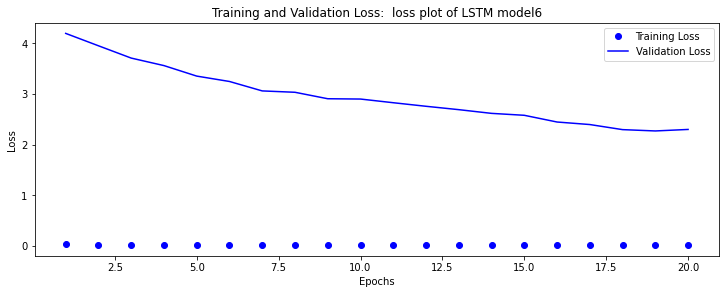

In [15]:
LSTM_model6 = models.Sequential()
LSTM_model6.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model6.add(layers.LSTM(50))


LSTM_model6.add(layers.Dense(1))

LSTM_model6.compile(optimizer=RMSprop(), loss='mse')
LSTM_model6_history = LSTM_model6.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model6_history, "loss plot of LSTM model6")

Epoch 1/30
13/13 [==============================] - 8s 389ms/step - loss: 0.0613 - val_loss: 3.8864
Epoch 2/30
13/13 [==============================] - 3s 229ms/step - loss: 0.0257 - val_loss: 3.6728
Epoch 3/30
13/13 [==============================] - 3s 266ms/step - loss: 0.0155 - val_loss: 3.5923
Epoch 4/30
13/13 [==============================] - 3s 239ms/step - loss: 0.0134 - val_loss: 3.5489
Epoch 5/30
13/13 [==============================] - 3s 236ms/step - loss: 0.0126 - val_loss: 3.5047
Epoch 6/30
13/13 [==============================] - 3s 233ms/step - loss: 0.0120 - val_loss: 3.4509
Epoch 7/30
13/13 [==============================] - 3s 239ms/step - loss: 0.0116 - val_loss: 3.3876
Epoch 8/30
13/13 [==============================] - 3s 238ms/step - loss: 0.0110 - val_loss: 3.3427
Epoch 9/30
13/13 [==============================] - 3s 225ms/step - loss: 0.0109 - val_loss: 3.2549
Epoch 10/30
13/13 [==============================] - 3s 229ms/step - loss: 0.0103 - val_loss: 3.1970

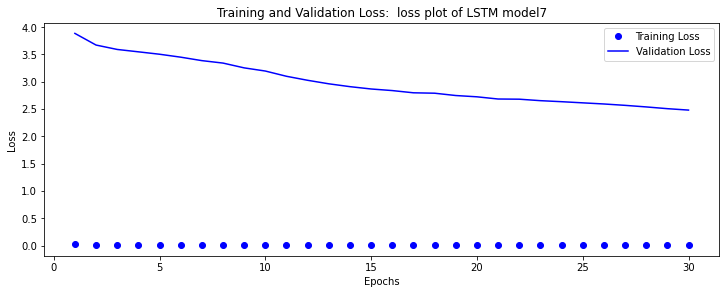

In [16]:
LSTM_model7 = models.Sequential()
LSTM_model7.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model7.add(layers.LSTM(32))


LSTM_model7.add(layers.Dense(1))

LSTM_model7.compile(optimizer=RMSprop(), loss='mse')
LSTM_model7_history = LSTM_model7.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model7_history, "loss plot of LSTM model7")

Epoch 1/20
13/13 [==============================] - 10s 363ms/step - loss: 0.0479 - val_loss: 3.9409
Epoch 2/20
13/13 [==============================] - 5s 313ms/step - loss: 0.0241 - val_loss: 3.7730
Epoch 3/20
13/13 [==============================] - 5s 362ms/step - loss: 0.0172 - val_loss: 3.6769
Epoch 4/20
13/13 [==============================] - 3s 254ms/step - loss: 0.0158 - val_loss: 3.6142
Epoch 5/20
13/13 [==============================] - 4s 297ms/step - loss: 0.0148 - val_loss: 3.5821
Epoch 6/20
13/13 [==============================] - 4s 331ms/step - loss: 0.0135 - val_loss: 3.5327
Epoch 7/20
13/13 [==============================] - 5s 417ms/step - loss: 0.0136 - val_loss: 3.5117
Epoch 8/20
13/13 [==============================] - 3s 255ms/step - loss: 0.0131 - val_loss: 3.4594
Epoch 9/20
13/13 [==============================] - 3s 244ms/step - loss: 0.0126 - val_loss: 3.4185
Epoch 10/20
13/13 [==============================] - 4s 318ms/step - loss: 0.0123 - val_loss: 3.374

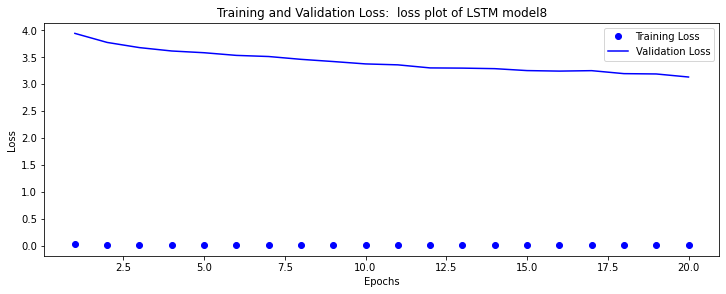

In [17]:
LSTM_model8 = models.Sequential()
LSTM_model8.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model8.add(layers.LSTM(32))


LSTM_model8.add(layers.Dense(1))

LSTM_model8.compile(optimizer=RMSprop(), loss='mse')
LSTM_model8_history = LSTM_model8.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model8_history, "loss plot of LSTM model8")

Epoch 1/30
13/13 [==============================] - 6s 259ms/step - loss: 0.0492 - val_loss: 3.7911
Epoch 2/30
13/13 [==============================] - 3s 201ms/step - loss: 0.0245 - val_loss: 3.7183
Epoch 3/30
13/13 [==============================] - 3s 208ms/step - loss: 0.0171 - val_loss: 3.7026
Epoch 4/30
13/13 [==============================] - 3s 208ms/step - loss: 0.0147 - val_loss: 3.6834
Epoch 5/30
13/13 [==============================] - 3s 209ms/step - loss: 0.0134 - val_loss: 3.6565
Epoch 6/30
13/13 [==============================] - 3s 210ms/step - loss: 0.0126 - val_loss: 3.6224
Epoch 7/30
13/13 [==============================] - 3s 204ms/step - loss: 0.0120 - val_loss: 3.5778
Epoch 8/30
13/13 [==============================] - 3s 217ms/step - loss: 0.0115 - val_loss: 3.5301
Epoch 9/30
13/13 [==============================] - 3s 198ms/step - loss: 0.0112 - val_loss: 3.4943
Epoch 10/30
13/13 [==============================] - 3s 210ms/step - loss: 0.0107 - val_loss: 3.4621

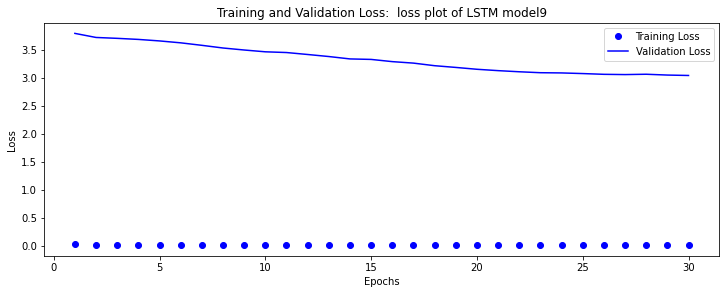

In [18]:
LSTM_model9 = models.Sequential()
LSTM_model9.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model9.add(layers.LSTM(16))


LSTM_model9.add(layers.Dense(1))

LSTM_model9.compile(optimizer=RMSprop(), loss='mse')
LSTM_model9_history = LSTM_model9.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model9_history, "loss plot of LSTM model9")

Epoch 1/20
13/13 [==============================] - 8s 349ms/step - loss: 0.0586 - val_loss: 3.6421
Epoch 2/20
13/13 [==============================] - 3s 236ms/step - loss: 0.0235 - val_loss: 3.5828
Epoch 3/20
13/13 [==============================] - 3s 234ms/step - loss: 0.0170 - val_loss: 3.5612
Epoch 4/20
13/13 [==============================] - 3s 234ms/step - loss: 0.0150 - val_loss: 3.5484
Epoch 5/20
13/13 [==============================] - 3s 224ms/step - loss: 0.0145 - val_loss: 3.5147
Epoch 6/20
13/13 [==============================] - 3s 232ms/step - loss: 0.0136 - val_loss: 3.4918
Epoch 7/20
13/13 [==============================] - 3s 223ms/step - loss: 0.0122 - val_loss: 3.4726
Epoch 8/20
13/13 [==============================] - 3s 231ms/step - loss: 0.0122 - val_loss: 3.4581
Epoch 9/20
13/13 [==============================] - 4s 322ms/step - loss: 0.0122 - val_loss: 3.4307
Epoch 10/20
13/13 [==============================] - 3s 235ms/step - loss: 0.0120 - val_loss: 3.3986

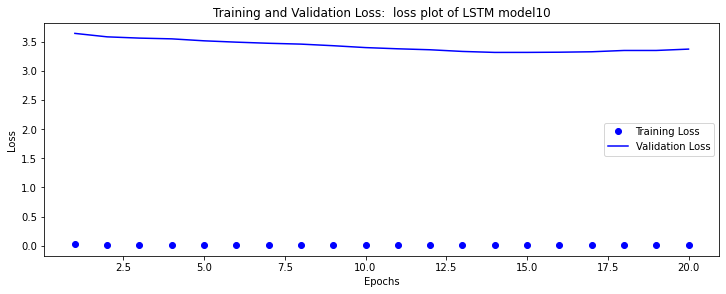

In [19]:
LSTM_model10 = models.Sequential()
LSTM_model10.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model10.add(layers.LSTM(16))


LSTM_model10.add(layers.Dense(1))

LSTM_model10.compile(optimizer=RMSprop(), loss='mse')
LSTM_model10_history = LSTM_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model10_history, "loss plot of LSTM model10")

Epoch 1/50
13/13 [==============================] - 8s 308ms/step - loss: 0.1486 - val_loss: 4.4087
Epoch 2/50
13/13 [==============================] - 3s 234ms/step - loss: 0.0430 - val_loss: 4.3897
Epoch 3/50
13/13 [==============================] - 3s 224ms/step - loss: 0.0202 - val_loss: 4.3898
Epoch 4/50
13/13 [==============================] - 3s 266ms/step - loss: 0.0148 - val_loss: 4.3915
Epoch 5/50
13/13 [==============================] - 4s 319ms/step - loss: 0.0127 - val_loss: 4.3891
Epoch 6/50
13/13 [==============================] - 3s 233ms/step - loss: 0.0116 - val_loss: 4.3810
Epoch 7/50
13/13 [==============================] - 3s 249ms/step - loss: 0.0115 - val_loss: 4.3690
Epoch 8/50
13/13 [==============================] - 3s 250ms/step - loss: 0.0111 - val_loss: 4.3437
Epoch 9/50
13/13 [==============================] - 4s 305ms/step - loss: 0.0107 - val_loss: 4.3224
Epoch 10/50
13/13 [==============================] - 3s 258ms/step - loss: 0.0109 - val_loss: 4.3134

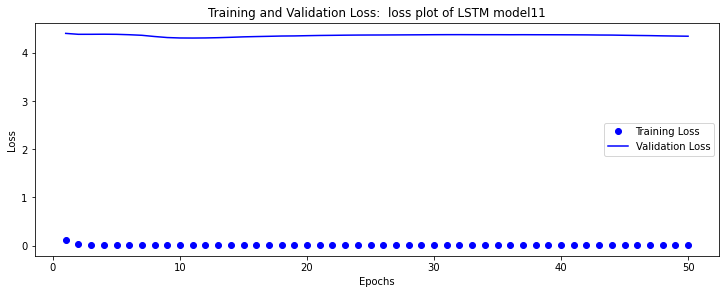

In [20]:
LSTM_model11 = models.Sequential()
LSTM_model11.add(layers.LSTM(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model11.add(layers.LSTM(5))


LSTM_model11.add(layers.Dense(1))

LSTM_model11.compile(optimizer=RMSprop(), loss='mse')
LSTM_model11_history = LSTM_model11.fit(train_dataset, epochs=50, validation_data=val_dataset)

plot_simple_loss(LSTM_model11_history, "loss plot of LSTM model11")

Epoch 1/20
13/13 [==============================] - 16s 717ms/step - loss: 0.0698 - val_loss: 3.7299
Epoch 2/20
13/13 [==============================] - 6s 497ms/step - loss: 0.0321 - val_loss: 3.6612
Epoch 3/20
13/13 [==============================] - 6s 429ms/step - loss: 0.0291 - val_loss: 3.5259
Epoch 4/20
13/13 [==============================] - 7s 526ms/step - loss: 0.0267 - val_loss: 3.4463
Epoch 5/20
13/13 [==============================] - 7s 576ms/step - loss: 0.0251 - val_loss: 3.2983
Epoch 6/20
13/13 [==============================] - 8s 611ms/step - loss: 0.0230 - val_loss: 3.2373
Epoch 7/20
13/13 [==============================] - 6s 490ms/step - loss: 0.0212 - val_loss: 3.1607
Epoch 8/20
13/13 [==============================] - 8s 609ms/step - loss: 0.0211 - val_loss: 3.1853
Epoch 9/20
13/13 [==============================] - 7s 549ms/step - loss: 0.0197 - val_loss: 3.1320
Epoch 10/20
13/13 [==============================] - 8s 600ms/step - loss: 0.0199 - val_loss: 3.063

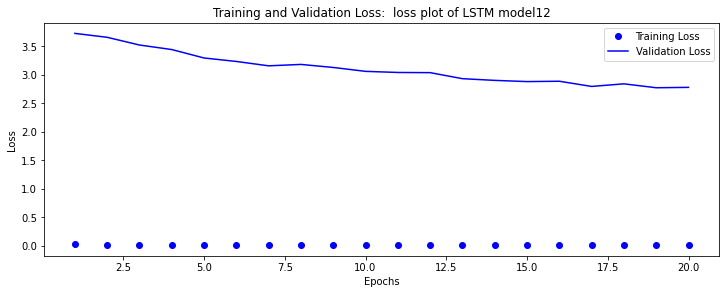

In [21]:
LSTM_model12 = models.Sequential()
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model12.add(layers.LSTM(50))


LSTM_model12.add(layers.Dense(1))

LSTM_model12.compile(optimizer=RMSprop(), loss='mse')
LSTM_model12_history = LSTM_model12.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model12_history, "loss plot of LSTM model12")

Epoch 1/20
13/13 [==============================] - 26s 924ms/step - loss: 0.0736 - val_loss: 3.7720
Epoch 2/20
13/13 [==============================] - 9s 671ms/step - loss: 0.0320 - val_loss: 3.8279
Epoch 3/20
13/13 [==============================] - 10s 698ms/step - loss: 0.0337 - val_loss: 3.7668
Epoch 4/20
13/13 [==============================] - 9s 718ms/step - loss: 0.0314 - val_loss: 3.6725
Epoch 5/20
13/13 [==============================] - 9s 683ms/step - loss: 0.0301 - val_loss: 3.6544
Epoch 6/20
13/13 [==============================] - 10s 825ms/step - loss: 0.0294 - val_loss: 3.6334
Epoch 7/20
13/13 [==============================] - 8s 653ms/step - loss: 0.0261 - val_loss: 3.5960
Epoch 8/20
13/13 [==============================] - 7s 583ms/step - loss: 0.0267 - val_loss: 3.5613
Epoch 9/20
13/13 [==============================] - 8s 631ms/step - loss: 0.0251 - val_loss: 3.4425
Epoch 10/20
13/13 [==============================] - 8s 598ms/step - loss: 0.0239 - val_loss: 3.4

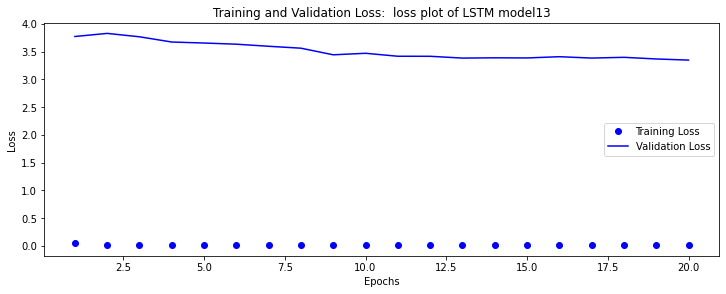

In [22]:
LSTM_model13 = models.Sequential()
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50))


LSTM_model13.add(layers.Dense(1))

LSTM_model13.compile(optimizer=RMSprop(), loss='mse')
LSTM_model13_history = LSTM_model13.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model13_history, "loss plot of LSTM model13")

Epoch 1/20
13/13 [==============================] - 7s 369ms/step - loss: 0.0497 - val_loss: 3.9136
Epoch 2/20
13/13 [==============================] - 4s 320ms/step - loss: 0.0235 - val_loss: 3.7303
Epoch 3/20
13/13 [==============================] - 4s 285ms/step - loss: 0.0217 - val_loss: 3.5582
Epoch 4/20
13/13 [==============================] - 4s 335ms/step - loss: 0.0194 - val_loss: 3.3920
Epoch 5/20
13/13 [==============================] - 3s 270ms/step - loss: 0.0173 - val_loss: 3.2837
Epoch 6/20
13/13 [==============================] - 4s 280ms/step - loss: 0.0161 - val_loss: 3.1735
Epoch 7/20
13/13 [==============================] - 5s 362ms/step - loss: 0.0155 - val_loss: 3.0750
Epoch 8/20
13/13 [==============================] - 4s 271ms/step - loss: 0.0146 - val_loss: 2.9277
Epoch 9/20
13/13 [==============================] - 4s 274ms/step - loss: 0.0137 - val_loss: 2.8643
Epoch 10/20
13/13 [==============================] - 4s 286ms/step - loss: 0.0130 - val_loss: 2.7101

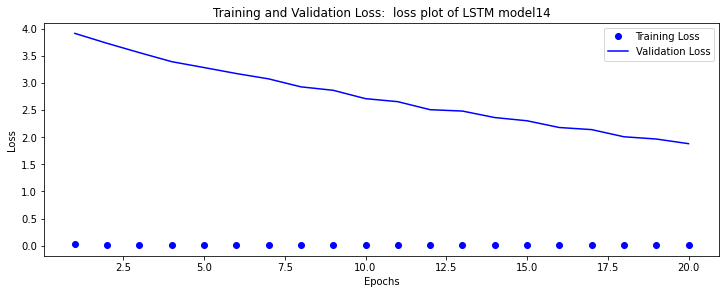

In [23]:
LSTM_model14 = models.Sequential()
LSTM_model14.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model14.add(layers.LSTM(32))


LSTM_model14.add(layers.Dense(1))

LSTM_model14.compile(optimizer=RMSprop(), loss='mse')
LSTM_model14_history = LSTM_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model14_history, "loss plot of LSTM model14")

Epoch 1/40
13/13 [==============================] - 6s 247ms/step - loss: 0.0863 - val_loss: 4.0318
Epoch 2/40
13/13 [==============================] - 2s 189ms/step - loss: 0.0295 - val_loss: 3.9994
Epoch 3/40
13/13 [==============================] - 2s 184ms/step - loss: 0.0223 - val_loss: 3.9723
Epoch 4/40
13/13 [==============================] - 2s 190ms/step - loss: 0.0176 - val_loss: 3.9420
Epoch 5/40
13/13 [==============================] - 3s 228ms/step - loss: 0.0143 - val_loss: 3.9159
Epoch 6/40
13/13 [==============================] - 5s 374ms/step - loss: 0.0121 - val_loss: 3.8926
Epoch 7/40
13/13 [==============================] - 3s 207ms/step - loss: 0.0106 - val_loss: 3.8720
Epoch 8/40
13/13 [==============================] - 3s 222ms/step - loss: 0.0097 - val_loss: 3.8553
Epoch 9/40
13/13 [==============================] - 3s 222ms/step - loss: 0.0091 - val_loss: 3.8423
Epoch 10/40
13/13 [==============================] - 3s 201ms/step - loss: 0.0088 - val_loss: 3.8315

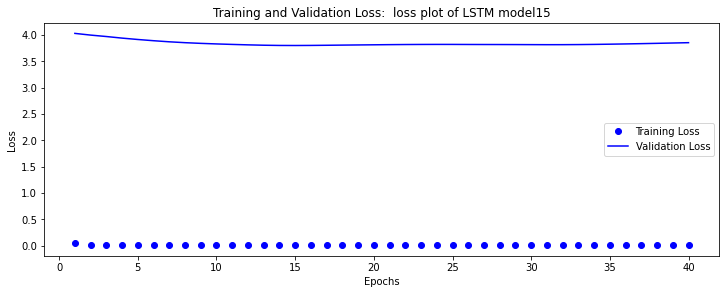

In [24]:
LSTM_model15 = models.Sequential()
LSTM_model15.add(layers.LSTM(16, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model15.add(layers.LSTM(16))


LSTM_model15.add(layers.Dense(1))

LSTM_model15.compile(optimizer=RMSprop(), loss='mse')
LSTM_model15_history = LSTM_model15.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(LSTM_model15_history, "loss plot of LSTM model15")

Epoch 1/20
13/13 [==============================] - 9s 515ms/step - loss: 0.0564 - val_loss: 3.5507
Epoch 2/20
13/13 [==============================] - 4s 327ms/step - loss: 0.0190 - val_loss: 3.4409
Epoch 3/20
13/13 [==============================] - 4s 351ms/step - loss: 0.0198 - val_loss: 3.2209
Epoch 4/20
13/13 [==============================] - 4s 333ms/step - loss: 0.0182 - val_loss: 3.0714
Epoch 5/20
13/13 [==============================] - 5s 387ms/step - loss: 0.0169 - val_loss: 2.9402
Epoch 6/20
13/13 [==============================] - 6s 491ms/step - loss: 0.0160 - val_loss: 2.8534
Epoch 7/20
13/13 [==============================] - 4s 344ms/step - loss: 0.0151 - val_loss: 2.7782
Epoch 8/20
13/13 [==============================] - 4s 345ms/step - loss: 0.0145 - val_loss: 2.6977
Epoch 9/20
13/13 [==============================] - 5s 364ms/step - loss: 0.0139 - val_loss: 2.6296
Epoch 10/20
13/13 [==============================] - 4s 332ms/step - loss: 0.0135 - val_loss: 2.5178

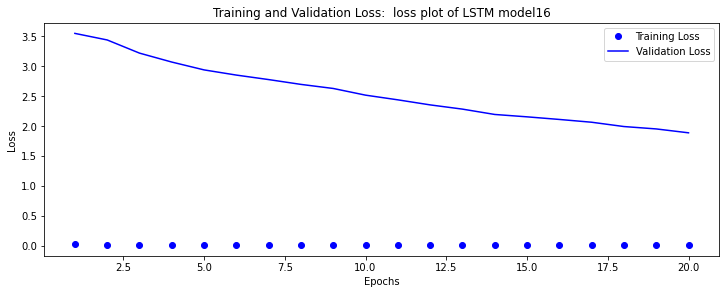

In [25]:
LSTM_model16 = models.Sequential()
LSTM_model16.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model16.add(layers.LSTM(64))


LSTM_model16.add(layers.Dense(1))

LSTM_model16.compile(optimizer=RMSprop(), loss='mse')
LSTM_model16_history = LSTM_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model16_history, "loss plot of LSTM model16")

Epoch 1/30
13/13 [==============================] - 12s 488ms/step - loss: 0.0526 - val_loss: 3.9147
Epoch 2/30
13/13 [==============================] - 5s 389ms/step - loss: 0.0377 - val_loss: 3.8430
Epoch 3/30
13/13 [==============================] - 5s 423ms/step - loss: 0.0292 - val_loss: 3.8079
Epoch 4/30
13/13 [==============================] - 6s 436ms/step - loss: 0.0253 - val_loss: 3.7816
Epoch 5/30
13/13 [==============================] - 6s 457ms/step - loss: 0.0232 - val_loss: 3.7640
Epoch 6/30
13/13 [==============================] - 6s 447ms/step - loss: 0.0214 - val_loss: 3.7461
Epoch 7/30
13/13 [==============================] - 6s 438ms/step - loss: 0.0207 - val_loss: 3.7318
Epoch 8/30
13/13 [==============================] - 6s 449ms/step - loss: 0.0193 - val_loss: 3.7121
Epoch 9/30
13/13 [==============================] - 5s 376ms/step - loss: 0.0195 - val_loss: 3.6872
Epoch 10/30
13/13 [==============================] - 6s 455ms/step - loss: 0.0181 - val_loss: 3.691

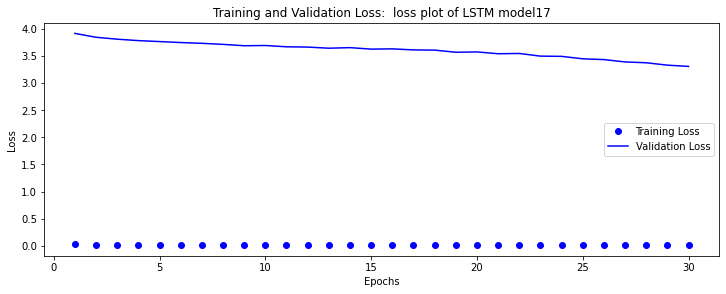

In [26]:
LSTM_model17 = models.Sequential()
LSTM_model17.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32))


LSTM_model17.add(layers.Dense(1))

LSTM_model17.compile(optimizer=RMSprop(), loss='mse')
LSTM_model17_history = LSTM_model17.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model17_history, "loss plot of LSTM model17")

Epoch 1/30
13/13 [==============================] - 11s 485ms/step - loss: 0.0426 - val_loss: 3.3031
Epoch 2/30
13/13 [==============================] - 4s 317ms/step - loss: 0.0246 - val_loss: 3.2441
Epoch 3/30
13/13 [==============================] - 4s 306ms/step - loss: 0.0224 - val_loss: 3.2033
Epoch 4/30
13/13 [==============================] - 4s 339ms/step - loss: 0.0206 - val_loss: 3.1580
Epoch 5/30
13/13 [==============================] - 4s 326ms/step - loss: 0.0197 - val_loss: 3.1402
Epoch 6/30
13/13 [==============================] - 4s 294ms/step - loss: 0.0185 - val_loss: 3.1111
Epoch 7/30
13/13 [==============================] - 4s 332ms/step - loss: 0.0179 - val_loss: 3.1257
Epoch 8/30
13/13 [==============================] - 5s 416ms/step - loss: 0.0169 - val_loss: 3.0829
Epoch 9/30
13/13 [==============================] - 5s 408ms/step - loss: 0.0164 - val_loss: 3.1077
Epoch 10/30
13/13 [==============================] - 4s 304ms/step - loss: 0.0156 - val_loss: 3.058

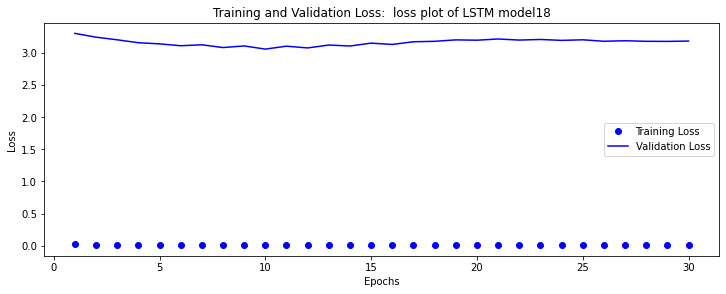

In [27]:
LSTM_model18 = models.Sequential()
LSTM_model18.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model18.add(layers.LSTM(32, return_sequences=True))
LSTM_model18.add(layers.LSTM(32))


LSTM_model18.add(layers.Dense(1))

LSTM_model18.compile(optimizer=RMSprop(), loss='mse')
LSTM_model18_history = LSTM_model18.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model18_history, "loss plot of LSTM model18")

In [28]:
histories = [LSTM_model1_history, LSTM_model2_history, LSTM_model3_history, LSTM_model4_history, LSTM_model5_history, LSTM_model6_history, LSTM_model7_history, LSTM_model8_history, LSTM_model9_history, LSTM_model10_history, LSTM_model11_history, LSTM_model12_history, LSTM_model13_history, LSTM_model14_history, LSTM_model15_history, LSTM_model16_history, LSTM_model17_history, LSTM_model18_history]

for i in range(0, len(histories)):
    val_loss, epoch = lowest_val_loss_and_epoch(histories[i])
    print(f"Model {i+1}: min val loss: {val_loss}, epoch: {epoch}")

Model 1: min val loss: 1.045928716659546, epoch: 20
Model 2: min val loss: 0.703748345375061, epoch: 20
Model 3: min val loss: 1.0171641111373901, epoch: 19
Model 4: min val loss: 1.3708311319351196, epoch: 18
Model 5: min val loss: 1.5639681816101074, epoch: 30
Model 6: min val loss: 2.268315553665161, epoch: 19
Model 7: min val loss: 2.481678009033203, epoch: 30
Model 8: min val loss: 3.131176471710205, epoch: 20
Model 9: min val loss: 3.0393261909484863, epoch: 30
Model 10: min val loss: 3.3158223628997803, epoch: 14
Model 11: min val loss: 4.312101364135742, epoch: 11
Model 12: min val loss: 2.7759523391723633, epoch: 19
Model 13: min val loss: 3.3470773696899414, epoch: 20
Model 14: min val loss: 1.8802284002304077, epoch: 20
Model 15: min val loss: 3.8017497062683105, epoch: 15
Model 16: min val loss: 1.888059139251709, epoch: 20
Model 17: min val loss: 3.306074619293213, epoch: 30
Model 18: min val loss: 3.0587992668151855, epoch: 10
